<a href="https://colab.research.google.com/github/MHosseinHashemi/Tuberculosis-Detection-using-X-Ray-images/blob/main/TB_Detection_TF_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
import io
import os
import gc
import cv2
import h5py
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import ipywidgets as widgets
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from google.colab import files
from sklearn.utils import shuffle
from warnings import filterwarnings
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
from IPython.display import display,clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L, EfficientNetV2S, EfficientNetV2B0
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# !pip install kaggle

In [5]:
# files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohammadhossein77","key":"baf77bc4d87e9f29e2f74205c19ea709"}'}

In [6]:
# ! mkdir ~/.kaggle

In [7]:
# ! cp kaggle.json ~/.kaggle/

In [8]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [9]:
# !kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

100% 661M/663M [00:33<00:00, 22.7MB/s]
100% 663M/663M [00:33<00:00, 20.6MB/s]


In [4]:
# import zipfile

# zip_ref = zipfile.ZipFile('/content/tuberculosis-tb-chest-xray-dataset.zip', 'r')

In [5]:
# zip_ref.extractall('/content/Dataset')

In [13]:
# zip_ref.close()

In [2]:
# # from tqdm import tqdm

# # Collecting all the correspounding addresses for the Pics
# def reader(image_dir):
#     images_path = []
#     # Reads all the paths to the images
#     for idx in tqdm(os.listdir(image_dir)):
#       img_path = os.path.join(image_dir, idx)
#       if img_path.endswith('.png'):
#         if "Tuberculosis" in idx:
#             images_path.append({"Address":img_path, "Label":"TB"})
#         elif "Normal" in idx:
#             images_path.append({"Address":img_path, "Label":"No"})
#         else:
#             print("Error! Something went wrong...")
#             print(img_path)

#     return images_path

In [6]:
# paths_1 = reader("/content/Dataset/TB_Chest_Radiography_Database/Normal")

In [7]:
# paths_2 = reader("/content/Dataset/TB_Chest_Radiography_Database/Tuberculosis")

In [17]:
# Expected to be 4200
# paths = paths_1 + paths_2
# len(paths)

4200

In [18]:
# import random
# random.shuffle(paths)
# # Double Check
# paths[:10]

[{'Address': '/content/Dataset/TB_Chest_Radiography_Database/Normal/Normal-2357.png',
  'Label': 'No'},
 {'Address': '/content/Dataset/TB_Chest_Radiography_Database/Normal/Normal-2992.png',
  'Label': 'No'},
 {'Address': '/content/Dataset/TB_Chest_Radiography_Database/Normal/Normal-977.png',
  'Label': 'No'},
 {'Address': '/content/Dataset/TB_Chest_Radiography_Database/Normal/Normal-131.png',
  'Label': 'No'},
 {'Address': '/content/Dataset/TB_Chest_Radiography_Database/Normal/Normal-3012.png',
  'Label': 'No'},
 {'Address': '/content/Dataset/TB_Chest_Radiography_Database/Normal/Normal-2771.png',
  'Label': 'No'},
 {'Address': '/content/Dataset/TB_Chest_Radiography_Database/Normal/Normal-855.png',
  'Label': 'No'},
 {'Address': '/content/Dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-300.png',
  'Label': 'TB'},
 {'Address': '/content/Dataset/TB_Chest_Radiography_Database/Normal/Normal-1080.png',
  'Label': 'No'},
 {'Address': '/content/Dataset/TB_Chest_Radiography_Data

In [19]:
# import data_and_label_augmentation as Datagenerator

# Augmentor = Datagenerator.Image_Custom_Augmentation(SP_intensity=False,
#                                     # RO_Key=15,
#                                     # Br_intensity=40,
#                                     H_Key = True,
#                                     V_Key = True)

In [ ]:
# input_path = "/content/Dataset/TB_Chest_Radiography_Database/Tuberculosis"
# output_path = "/content/drive/MyDrive/Colab Notebooks/New_dataset/TB"

# Augmentor.Generate_Data(input_path,output_path)

In [8]:
# TBs = len(os.listdir("/content/drive/MyDrive/Colab Notebooks/New_dataset/TB"))
# Normals = len(os.listdir("/content/drive/MyDrive/Colab Notebooks/New_dataset/Normal"))
# print(f"Number of Normal Samples: {Normals}\nNumber of Tuberculosis Samples: {TBs}")

Number of Normal Samples: 3500
Number of Tuberculosis Samples: 1400


# Defining a function to create CNN model

In [2]:
image_size = 512
MobileNetV2 = MobileNetV2(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
model = MobileNetV2.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(1,activation='sigmoid')(model)
model = tf.keras.models.Model(inputs=MobileNetV2.input, outputs = model)

In [3]:
opt = SGD(learning_rate=0.008)
model.compile(loss='binary_crossentropy', optimizer = opt, metrics= ['accuracy','Recall','Precision'])

In [4]:
# csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Tensorflow_Logs/MobileNetV2.csv', separator=",")
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Tensorflow_Logs/MobileNetV2.h5", monitor="val_recall", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_recall',
                              factor = 0.8,
                              patience = 3,
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

In [5]:
def train_generator(TRAINING_DIR):

    train_datagen = ImageDataGenerator(rescale=1/255)
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=4,
                                                        class_mode='binary',
                                                        target_size=(512, 512))

    return train_generator

In [6]:
def test_generator(TEST_DIR):

    test_datagen = ImageDataGenerator(rescale=1/255)
    test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                      batch_size=4,
                                                      class_mode='binary',
                                                      target_size=(512,512))

    return test_generator

In [17]:
# from sklearn.model_selection import *
# import shutil
# import os
# import random

# def shuffle_and_split_data(src_dir, dest_dir, split_percent):
#     # Get the list of image filenames in the source directory
#     image_filenames = os.listdir(src_dir)
#     num_images = len(image_filenames)

#     # Shuffle the image filenames
#     random.shuffle(image_filenames)

#     # Calculate the number of images to move to the validation set
#     num_images_to_move = int(num_images * split_percent)

#     # Move the images to the destination directory
#     for i in tqdm(range(num_images_to_move)):
#         image_filename = image_filenames[i]
#         src_path = os.path.join(src_dir, image_filename)
#         dest_path = os.path.join(dest_dir, image_filename)
#         shutil.move(src_path, dest_path)

# # Paths to the source and destination directories
# train_tb_dir = "/content/drive/MyDrive/Colab Notebooks/New_dataset/TB"
# train_normal_dir = "/content/drive/MyDrive/Colab Notebooks/New_dataset/Normal"
# validation_dir = "/content/drive/MyDrive/Colab Notebooks/New_dataset/validation"
# os.makedirs(validation_dir, exist_ok=True)

# # Create the Normal and TB directories inside the validation directory
# validation_normal_dir = os.path.join(validation_dir, "Normal")
# validation_tb_dir = os.path.join(validation_dir, "TB")
# os.makedirs(validation_normal_dir, exist_ok=True)
# os.makedirs(validation_tb_dir, exist_ok=True)

# # Shuffle and move Normal images to the validation set
# split_percent = 0.25
# shuffle_and_split_data(train_normal_dir, validation_normal_dir, split_percent)

# # Shuffle and move TB images to the validation set
# shuffle_and_split_data(train_tb_dir, validation_tb_dir, split_percent)

# print("Data shuffling and splitting complete.")


100%|██████████| 350/350 [00:01<00:00, 343.79it/s]

Data shuffling and splitting complete.


In [7]:
TBs = len(os.listdir("/content/drive/MyDrive/Colab Notebooks/New_dataset/train/TB"))
Normals = len(os.listdir("/content/drive/MyDrive/Colab Notebooks/New_dataset/train/Normal"))
print(f"Number of Normal train Samples: {Normals}\nNumber of Tuberculosis train Samples: {TBs}")

Number of Normal train Samples: 2625
Number of Tuberculosis train Samples: 1050


In [8]:
TBs = len(os.listdir("/content/drive/MyDrive/Colab Notebooks/New_dataset/validation/TB"))
Normals = len(os.listdir("/content/drive/MyDrive/Colab Notebooks/New_dataset/validation/Normal"))
print(f"Number of Normal validation Samples: {Normals}\nNumber of Tuberculosis validation Samples: {TBs}")

Number of Normal validation Samples: 875
Number of Tuberculosis validation Samples: 350


In [9]:
Train_Dir = '/content/drive/MyDrive/Colab Notebooks/New_dataset/train'
Test_Dir = '/content/drive/MyDrive/Colab Notebooks/New_dataset/validation'

In [10]:
train_generator = train_generator(TRAINING_DIR=Train_Dir)

Found 3675 images belonging to 2 classes.


In [11]:
validation_generator = test_generator(TEST_DIR=Test_Dir)

Found 1225 images belonging to 2 classes.


In [12]:
EPOCHS = 80

history_1 = model.fit(
        train_generator,
        steps_per_epoch=50,
        epochs=EPOCHS,
        verbose=1,
        validation_data = validation_generator,
        callbacks=[checkpoint, reduce_lr]
        )

Epoch 1/80
50/50 [==============================] - ETA: 0s - loss: 0.3886 - accuracy: 0.8550 - recall: 0.6316 - precision: 0.8182
Epoch 1: val_recall improved from inf to 0.99429, saving model to /content/drive/MyDrive/Colab Notebooks/Tensorflow_Logs/MobileNetV2.h5
50/50 [==============================] - 45s 544ms/step - loss: 0.3886 - accuracy: 0.8550 - recall: 0.6316 - precision: 0.8182 - val_loss: 0.8635 - val_accuracy: 0.2939 - val_recall: 0.9943 - val_precision: 0.2874 - lr: 0.0080
Epoch 2/80
50/50 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.9450 - recall: 0.9123 - precision: 0.8966
Epoch 2: val_recall improved from 0.99429 to 0.98571, saving model to /content/drive/MyDrive/Colab Notebooks/Tensorflow_Logs/MobileNetV2.h5
50/50 [==============================] - 24s 480ms/step - loss: 0.1850 - accuracy: 0.9450 - recall: 0.9123 - precision: 0.8966 - val_loss: 0.5030 - val_accuracy: 0.7616 - val_recall: 0.9857 - val_precision: 0.5459 - lr: 0.0080
Epoch 3/

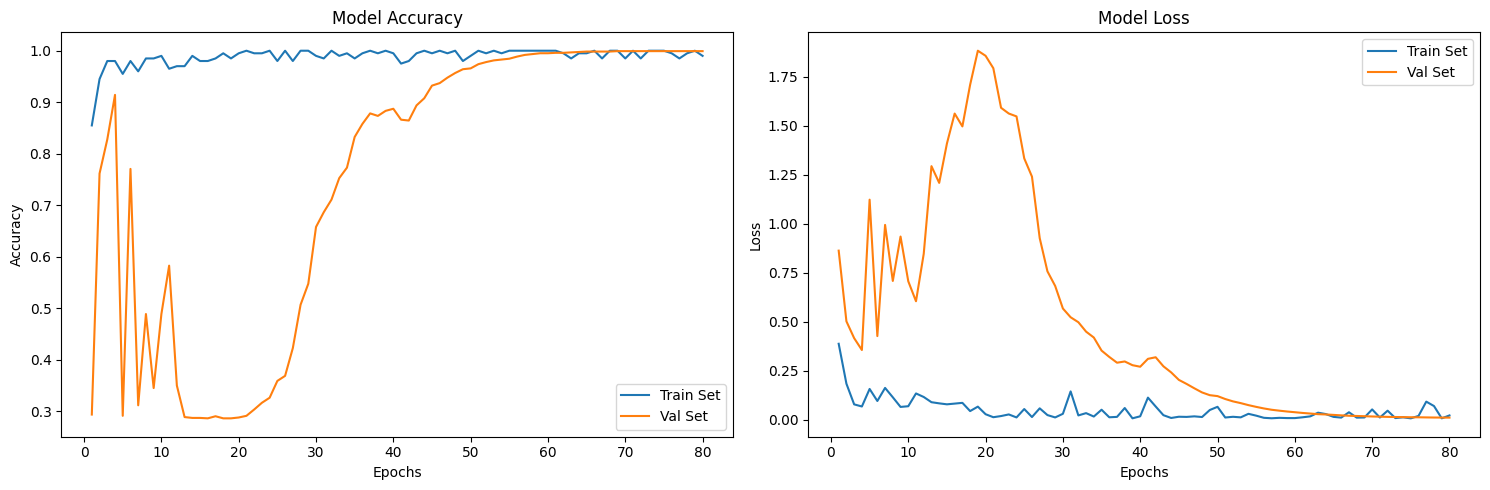

In [15]:
# plot model performance
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs_range = range(1, len(history_1.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

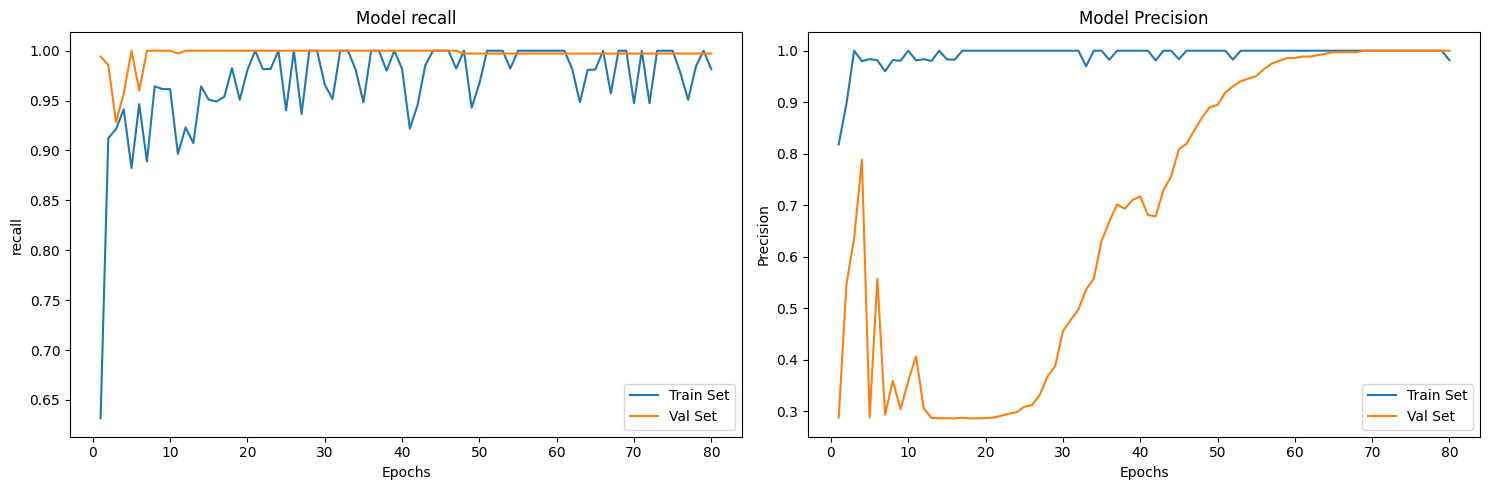

In [16]:
# plot model performance
acc = history_1.history['recall']
val_acc = history_1.history['val_recall']
loss = history_1.history['precision']
val_loss = history_1.history['val_precision']
epochs_range = range(1, len(history_1.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('recall')
plt.title('Model recall')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Model Precision')

plt.tight_layout()
plt.show()